# Amazon Review Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'amazon_reviews.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()

# Display the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254 entries, 0 to 3253
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            3254 non-null   int64  
 1   reviewerName          3253 non-null   object 
 2   overall               3254 non-null   float64
 3   reviewText            3253 non-null   object 
 4   reviewTime            3253 non-null   object 
 5   day_diff              3253 non-null   float64
 6   helpful_yes           3253 non-null   float64
 7   helpful_no            3253 non-null   float64
 8   total_vote            3253 non-null   float64
 9   score_pos_neg_diff    3253 non-null   float64
 10  score_average_rating  3253 non-null   float64
 11  wilson_lower_bound    3253 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 305.2+ KB


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Data Cleaning

We start by removing unnecessary columns and handling missing values.

In [19]:
# Drop the 'Unnamed: 0' column as it's not needed
df_cleaned = df.drop(columns=['Unnamed: 0'])


# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

### 2. Exploratory Data Analysis (EDA)

In this step, we analyze the distribution of ratings and other key variables such as the helpfulness of the reviews.

In [3]:
# Distribution of ratings
rating_distribution = df_cleaned['overall'].value_counts().sort_index()
print("Rating Distribution:\n", rating_distribution)

# Summary statistics for helpful votes
helpful_summary = df_cleaned[['helpful_yes', 'helpful_no', 'total_vote']].describe()
print("\nSummary Statistics for Helpful Votes:\n", helpful_summary)

Rating Distribution:
 overall
1.0     157
2.0      45
3.0      84
4.0     358
5.0    2607
Name: count, dtype: int64

Summary Statistics for Helpful Votes:
        helpful_yes   helpful_no   total_vote
count  3251.000000  3251.000000  3251.000000
mean      0.899723     0.196863     1.096586
std      35.059437     4.147734    36.794413
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000
max    1952.000000   183.000000  2020.000000


### 3. Sentiment Analysis Preparation

We prepare the text data for sentiment analysis. Reviews are classified as positive (rating > 3) or negative (rating ≤ 3).
We also clean the review text by removing special characters and converting everything to lowercase.

In [4]:
# Create a binary sentiment column based on the overall rating
df_cleaned['sentiment'] = df_cleaned['overall'].apply(lambda x: 1 if x > 3 else 0)

# Clean the review text
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df_cleaned['cleaned_reviewText'] = df_cleaned['reviewText'].apply(clean_text)

### 4. Model Building and Evaluation

We build and evaluate a logistic regression model to classify the sentiment of reviews.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data
X = df_cleaned['cleaned_reviewText']
y = df_cleaned['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Build a logistic regression model
model = LogisticRegression()
model.fit(X_train_vect, y_train)

# Predict on the test set
y_pred = model.predict(X_test_vect)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy*100:.2f}%")
print("Classification Report:\n", report)

Model Accuracy: 91.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.07      0.13        58
           1       0.92      1.00      0.96       593

    accuracy                           0.92       651
   macro avg       0.86      0.53      0.54       651
weighted avg       0.91      0.92      0.88       651



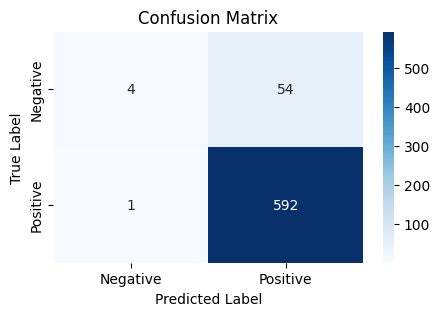

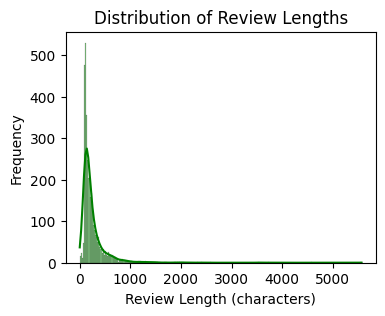

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Step 1: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 2: ROC Curve and AUC
y_pred_prob = model.predict_proba(X_test_vect)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)


# Step 3: Distribution of Review Lengths (insight on review quality)
df_cleaned['review_length'] = df_cleaned['cleaned_reviewText'].apply(len)

plt.figure(figsize=(4, 3))
sns.histplot(df_cleaned['review_length'], kde=True, color="green")
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.show()




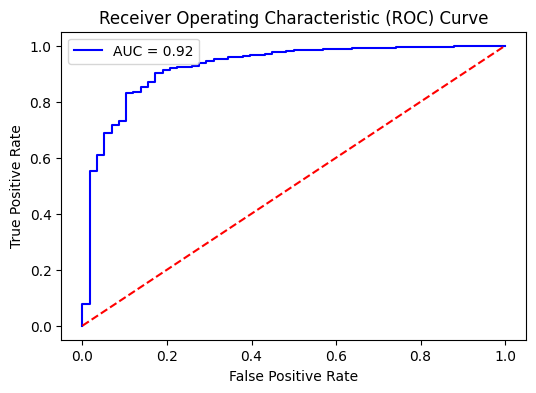

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

<Axes: xlabel='overall', ylabel='helpful_yes'>

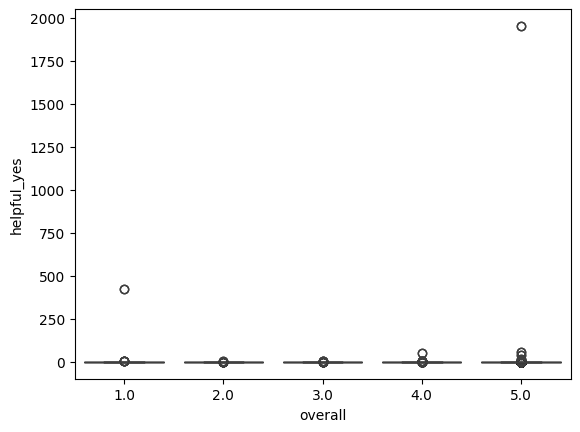

In [7]:
# Option 1: Use hue and set legend=False
sns.boxplot(x='overall', y='helpful_yes', hue='overall', data=df_cleaned, legend=False)

# Option 2: Remove palette if not using hue
sns.boxplot(x='overall', y='helpful_yes', data=df_cleaned)


### 5. Conclusion

The model achieved an accuracy of 91.55%. While the model performed well, it struggled with negative reviews due to the imbalanced data.
This analysis provides a strong foundation for further improvement, such as exploring advanced models or handling data imbalance. The analysis provides a robust sentiment classification model and actionable insights that can be leveraged to enhance customer satisfaction, reduce negative reviews, and optimize the e-commerce operations of Amazon. By addressing common issues identified in the reviews and improving post-purchase support, Amazon can further solidify its market position and ensure a seamless shopping experience for its customers.